In [1]:
import pandas as pd
import openpyxl
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
from sklearn.metrics import adjusted_rand_score

In [2]:
noc_roma = pd.read_csv("../NOC_ROMA_202403110800-202403111600_clusters_la.csv")

In [3]:
noc_roma['correct_label'] = noc_roma['NOTE SPV'].apply(lambda x: 0 if 'CORRELAZIONE OK' in x else 1)

## Statistics

In [4]:
noc_roma_grouped = noc_roma.groupby("cluster_id")
numero_cluster = noc_roma["cluster_id"].nunique()

cluster_corretti = []
cluster_totalmente_errati = []
cluster_parzialmente_corretti = []

for cluster_id, gruppo in noc_roma.groupby("cluster_id"):
    if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK").all():
        cluster_corretti.append(cluster_id)
    elif gruppo["NOTE SPV"].str.contains("CORRELAZIONE ERRATA").all():
        cluster_totalmente_errati.append(cluster_id)
    else:
        cluster_parzialmente_corretti.append(cluster_id)

print("Numero Cluster:", numero_cluster)
print(f"Numero di cluster corretti: {len(cluster_corretti)}")
print(f"Numero di cluster totalmente errati: {len(cluster_totalmente_errati)}")
print(f"Numero di cluster parzialmente corretti: {len(cluster_parzialmente_corretti)}")


Numero Cluster: 35
Numero di cluster corretti: 13
Numero di cluster totalmente errati: 12
Numero di cluster parzialmente corretti: 10


## Single n_neighbors value LOF

In [5]:
import numpy as np
import pandas as pd


# Assicurati che "first_occurrence" sia in formato datetime
noc_roma["first_occurrence"] = pd.to_datetime(noc_roma["first_occurrence"])

outlier_labels = []
df_list = []


for cluster_id, group in noc_roma.groupby("cluster_id"):
    # Convertire i tempi in numeri
    X = group[["first_occurrence"]].apply(lambda x: x.astype(np.int64) // 10**9).values.reshape(-1, 1)
    
    # Applicazione del Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=2, contamination="auto")
    labels = lof.fit_predict(X)
    outlier_labels.extend(labels)
    
    # Creazione di un DataFrame temporaneo con i risultati
    temp_df = pd.DataFrame({
        "cluster_id": cluster_id,
        "OUTLIER_LABEL": labels,
    })
    
    df_list.append(temp_df)

final_df = pd.concat(df_list, ignore_index=True)
filtered_noc_roma = noc_roma[["NOTE SPV"]]

# Merge dei risultati con il DataFrame originale
merge_df = pd.merge(final_df, filtered_noc_roma, left_index=True, right_index=True, how="left")



In [6]:
merge_grouped = merge_df.groupby("cluster_id")

reconstructed_correct_clusters = 0
for cluster_id, group in merge_grouped:

    if cluster_id in cluster_corretti:
        if group["OUTLIER_LABEL"].nunique() == 1:
            reconstructed_correct_clusters += 1

print(
    f"Numero di cluster corretti ricostruiti correttamente: {reconstructed_correct_clusters} di {len(cluster_corretti)}"
)


partially_correct_clusters_predicted = 0

for cluster_id, group in merge_grouped:

    if cluster_id in cluster_parzialmente_corretti:
        # Filtra gli allarmi con "CORRELAZIONE OK"
        allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
        # Filtra gli allarmi con "CORRELAZIONE ERRATA"
        allarmi_errata = group[
            group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
        ]

        # Verifica che tutti gli allarmi OK abbiano la stessa label
        label_unica_ok = allarmi_ok["OUTLIER_LABEL"].nunique() == 1

        # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
        if not allarmi_errata.empty and label_unica_ok:
            label_ok = allarmi_ok["OUTLIER_LABEL"].iloc[0]
            # Verifica che tutte le label ERRATA siano diverse da quella OK
            label_diverse_errata = (
                not allarmi_errata["OUTLIER_LABEL"].isin([label_ok]).any()
            )

            if label_diverse_errata:
                partially_correct_clusters_predicted += 1

print(
    f"Numero di cluster corretti ricostruiti correttamente: {partially_correct_clusters_predicted} di {len(cluster_parzialmente_corretti)}"
)

merge_df.to_excel("LOF_df.xlsx", index=False)

Numero di cluster corretti ricostruiti correttamente: 7 di 13
Numero di cluster corretti ricostruiti correttamente: 2 di 10


## Multiple n_neighbors value LOF

Valori di n_neighbors : 100%|██████████| 61/61 [00:06<00:00,  9.18it/s]


reconstructed_correct_clusters_values [3 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
cluster_corretti_values [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13]


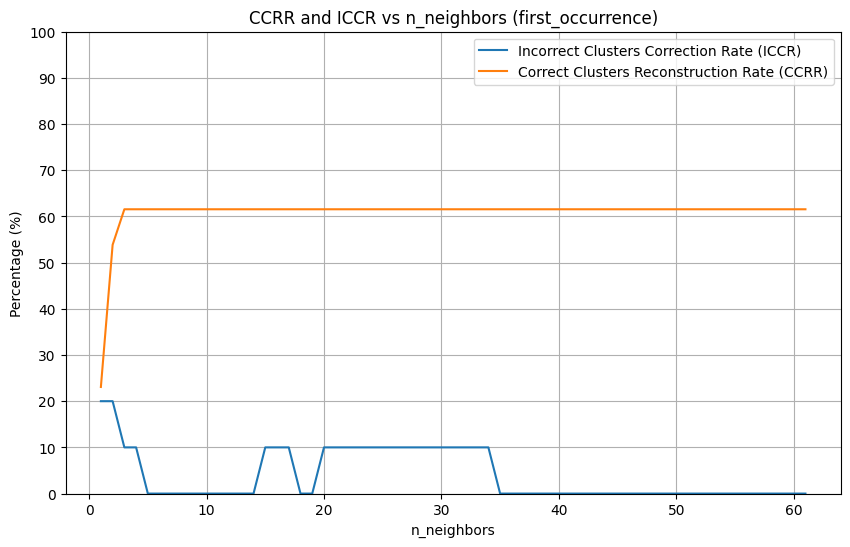

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Numero massimo di allarmi in un cluster
global_max_alarms = noc_roma.groupby("cluster_id").size().max()


n_neighbors_range = np.arange(1, global_max_alarms+1, 1)

cluster_labels = []
df_list = []
ari_scores = []
average_ari_scores_values = []
results = []
reconstructed_correct_clusters_values = []
partially_correct_clusters_predicted_values = []
cluster_corretti_values = []
cluster_parzialmente_corretti_values = []

for n in tqdm(n_neighbors_range, desc="Valori di n_neighbors "):

    df_list = []

    for cluster_id, group in noc_roma.groupby("cluster_id"):
        # Convertire i tempi in numeri
        X = (
            group[["first_occurrence"]]
            .apply(lambda x: x.astype(np.int64) // 10**9)
            .values.reshape(-1, 1)
        )
        if n > len(X):
            n = len(X)

        # Applicazione del Local Outlier Factor
        lof = LocalOutlierFactor(n_neighbors=n, contamination="auto")
        labels = lof.fit_predict(X)
        true_labels_for_group = group["correct_label"].values
        if cluster_id not in cluster_totalmente_errati:
            ari_score = adjusted_rand_score(true_labels_for_group, labels)
            ari_scores.append(ari_score)

        # Creazione di un DataFrame temporaneo con i risultati
        temp_df = pd.DataFrame(
            {
                "cluster_id": cluster_id,
                "OUTLIER_LABEL": labels,
            }
        )

        df_list.append(temp_df)
    
    average_ari_scores_values.append(np.mean(ari_scores))
    final_df = pd.concat(df_list, ignore_index=True)
    filtered_noc_roma = noc_roma[["NOTE SPV"]]

    merge_df = pd.merge(
        final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
    )

    merge_grouped = merge_df.groupby("cluster_id")

    predict_correct_clusters = 0
    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_corretti:
            if group["OUTLIER_LABEL"].nunique() == 1:
                predict_correct_clusters += 1

    reconstructed_correct_clusters_values.append(predict_correct_clusters)
    cluster_corretti_values.append(len(cluster_corretti))

    predict_wrong_clusters = 0

    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_parzialmente_corretti:
            if cluster_id in cluster_parzialmente_corretti:
                # Filtra gli allarmi con "CORRELAZIONE OK"
                allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
                # Filtra gli allarmi con "CORRELAZIONE ERRATA"
                allarmi_errata = group[
                    group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
                ]

                # Verifica che tutti gli allarmi OK abbiano la stessa label
                label_unica_ok = allarmi_ok["OUTLIER_LABEL"].nunique() == 1

                # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
                if not allarmi_errata.empty and label_unica_ok:
                    label_ok = allarmi_ok["OUTLIER_LABEL"].iloc[0]
                    # Verifica che tutte le label ERRATA siano diverse da quella OK
                    label_diverse_errata = (
                        not allarmi_errata["OUTLIER_LABEL"].isin([label_ok]).any()
                    )

                    if label_diverse_errata:
                        predict_wrong_clusters += 1
    partially_correct_clusters_predicted_values.append(predict_wrong_clusters)
    cluster_parzialmente_corretti_values.append(len(cluster_parzialmente_corretti))


plt.figure(figsize=(10, 6))


reconstructed_correct_clusters_values = np.array(reconstructed_correct_clusters_values)
cluster_corretti_values = np.array(cluster_corretti_values)
partially_correct_clusters_predicted_values = np.array(partially_correct_clusters_predicted_values)
cluster_parzialmente_corretti_values = np.array(cluster_parzialmente_corretti_values)

print("reconstructed_correct_clusters_values", reconstructed_correct_clusters_values)
print("cluster_corretti_values", cluster_corretti_values)
# Calcolo delle percentuali
cluster_corretti_percentage = reconstructed_correct_clusters_values / cluster_corretti_values * 100
cluster_parzialmente_corretti_percentage = partially_correct_clusters_predicted_values / cluster_parzialmente_corretti_values * 100

# Plot dei valori percentuali
plt.plot(
    n_neighbors_range,
    cluster_parzialmente_corretti_percentage,
    label="Incorrect Clusters Correction Rate (ICCR)",
)
plt.plot(
    n_neighbors_range,
    cluster_corretti_percentage,
    label="Correct Clusters Reconstruction Rate (CCRR)",
)


plt.xlabel("n_neighbors")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)  # Imposta i limiti dell'asse y da 0% a 100%
plt.yticks(np.arange(0, 101, 10))  # Imposta i ticks dell'asse y da 0 a 100 con passo 10
plt.title("CCRR and ICCR vs n_neighbors (first_occurrence)")
plt.legend()
plt.grid(True)


plt.show()

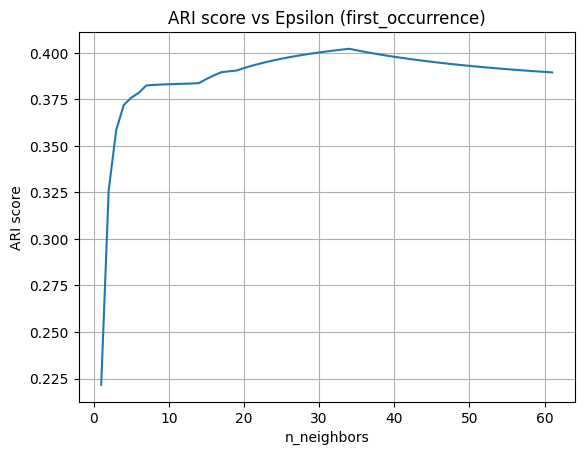

In [13]:
plt.plot(
    n_neighbors_range,
    average_ari_scores_values
)


plt.xlabel("n_neighbors")
plt.ylabel("ARI score")
plt.title("ARI score vs Epsilon (first_occurrence)")
plt.grid(True)


plt.show()